# Ensemble: siconc

## Imports & defaults

In [1]:
import libs.analysis
import libs.ensemble
import libs.local
import libs.plot
import libs.vars
import matplotlib

matplotlib.rcParams.update({ 'font.size': 18 })

/home/users/woodward/.conda/envs/climate/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


## Data

In [2]:
# ----- SPECIFIC SETTINGS -----
component = 'SImon'
experiment = 'ssp585'
variable_id = 'siconc'

spatial_text = 'sea-ice concentration'
spatial_units = '%'

conf = [v for v in libs.vars.variables() if v['variable_id'] == variable_id][0]
time_series_text = conf['text']
time_series_weighted_method = conf['weighting_method']
time_series_units = conf['units']
time_series_y_label = f'Area ({time_series_units})'
time_series_y_range = (0, 1.2e7)
time_series_y_range_full = (0, 1.2e7)
time_series_y_range_monthly = (0, 1.2e7)
time_series_y_range_regional = (0, 3.5e6)

# Convert from m2 to km2 and % to fraction
time_series_process = conf['weighting_process']

colormesh_kwargs = {
    'extend': 'neither',
    'levels': 11,
    #'shading': 'auto', # NB change to 'gouraud' if Jaspy
    'vmin': 0,
    'vmax': 100,
    'x': 'longitude', 
    'y': 'latitude'
}

In [3]:
ensemble, weight = libs.ensemble.get_and_preprocess(
    component, 
    experiment, 
    variable_id
)

ensemble_time_series = libs.local.get_ensemble_series(variable_id, experiment)
ensemble_time_series_smooth = libs.local.get_ensemble_series(variable_id, experiment, suffix='_smooth')

time_slices = libs.vars.default_time_slices()
ensemble_time_slices = libs.analysis.generate_slices(ensemble)

Error 404
-> _data/cmip6/HadGEM3-GC31-MM/siconc/siconc_SImon_HadGEM3-GC31-MM_ssp585_r1i1p1f3_gn_201501-210012_processed.nc
Error 404
-> _data/cmip6/MPI-ESM1-2-LR/siconc/siconc_SImon_MPI-ESM1-2-LR_ssp585_r1i1p1f1_gn_201501-210012_processed.nc


## Time series

### Mean

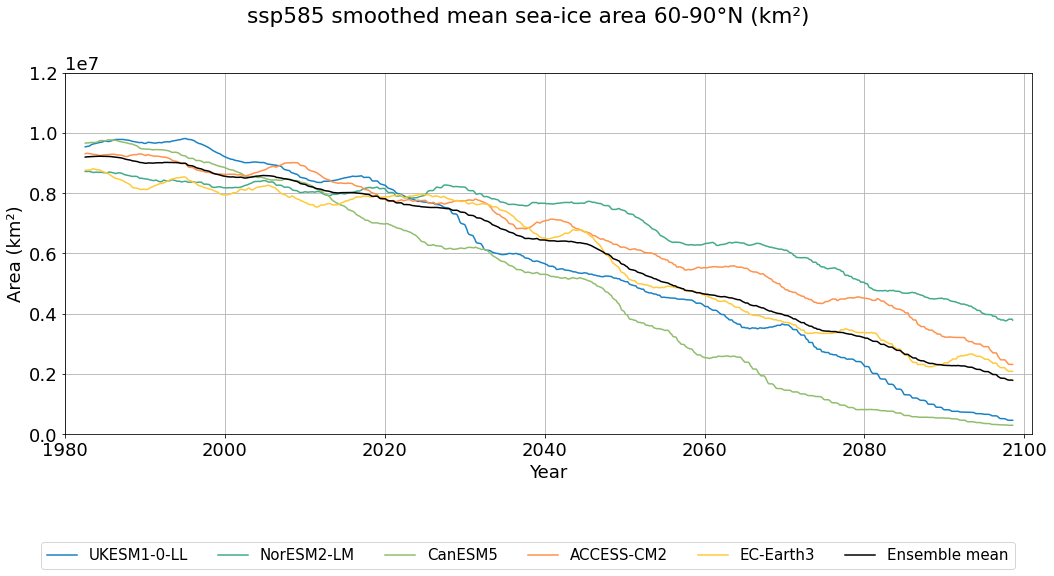

In [4]:
libs.plot.time_series_from_vars(
    ensemble_time_series_smooth,
    title=f'{experiment} smoothed mean {time_series_text} 60-90°N ({time_series_units})',
    xattr='time',
    ylabel=time_series_y_label,
    yrange=time_series_y_range
)

### September (min) & March (max)

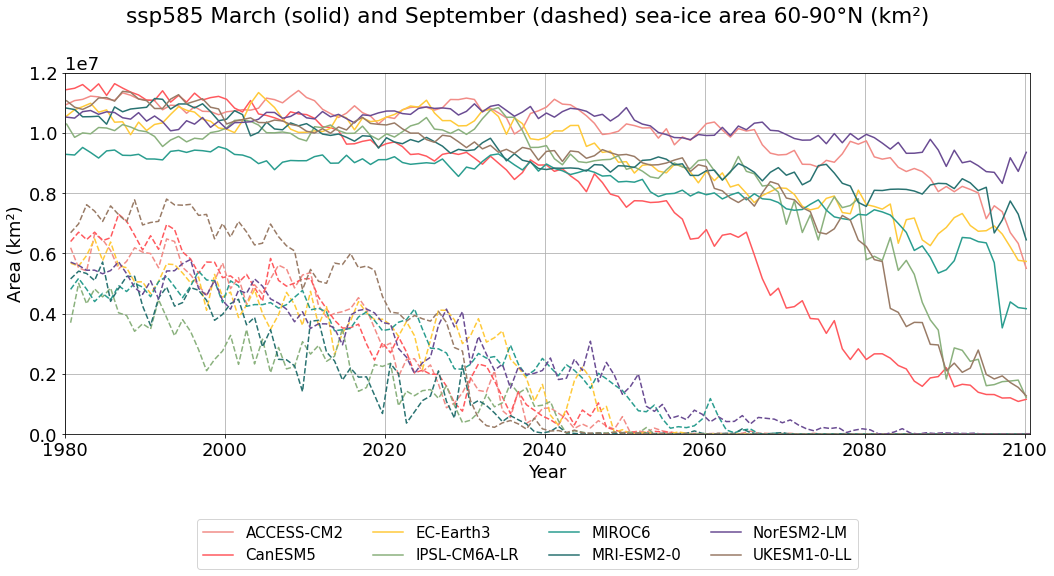

In [5]:
ensemble_weighted_reduced_sep_mar = []

for item in ensemble:
    item_data = time_series_process(item['data'])    
    item_base_kwargs = {
        'color': item['color'],
        'label': item['label']
    }

    # Reduce data, i.e. taking sum or average over spatial dimensions
    item_weighted_sep = item_data.where(item_data.time['time.month'] == 9, drop=True).weighted(weight)
    item_reduced_sep = getattr(
        item_weighted_sep, 
        time_series_weighted_method
    )(dim=item_weighted_sep.weights.dims, skipna=True)
    
    item_weighted_mar = item_data.where(item_data.time['time.month'] == 3, drop=True).weighted(weight)
    item_reduced_mar = getattr(
        item_weighted_mar, 
        time_series_weighted_method
    )(dim=item_weighted_mar.weights.dims, skipna=True)

    ensemble_weighted_reduced_sep_mar.append({ **item_base_kwargs, **{ 
        'data': item_reduced_mar
    } })
    ensemble_weighted_reduced_sep_mar.append({ **item_base_kwargs, **{ 
        'data': item_reduced_sep,
        'plot_kwargs': { 'linestyle': 'dashed' },
    } })


libs.plot.time_series(
    ensemble_weighted_reduced_sep_mar,
    cols=4,
    title=f'{experiment} March (solid) and September (dashed) {time_series_text} 60-90°N ({time_series_units})',
    xattr='time',
    ylabel=time_series_y_label,
    yrange=time_series_y_range
)

### Full variability

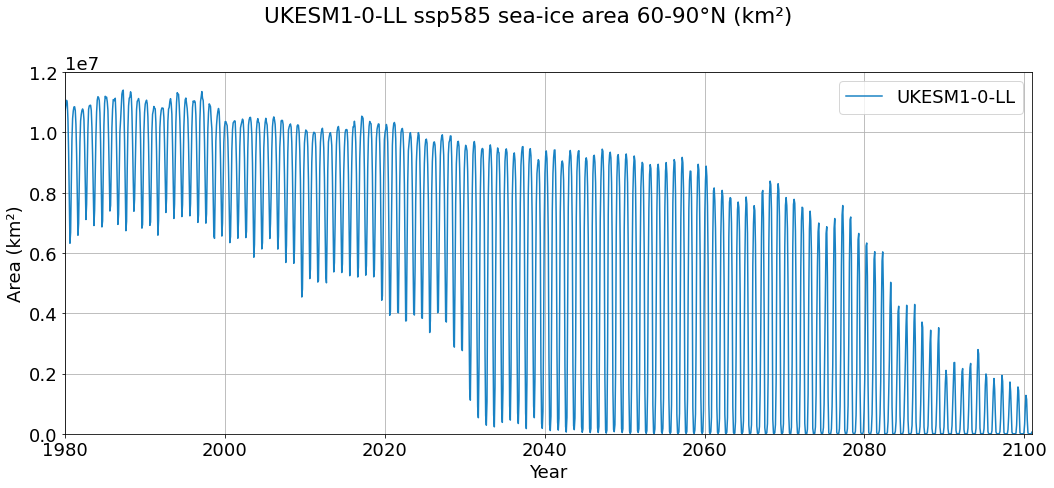

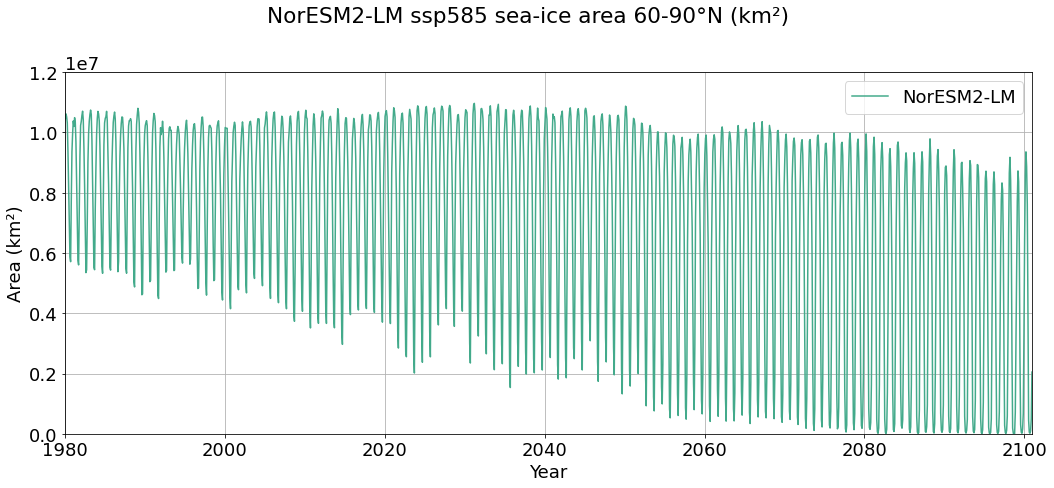

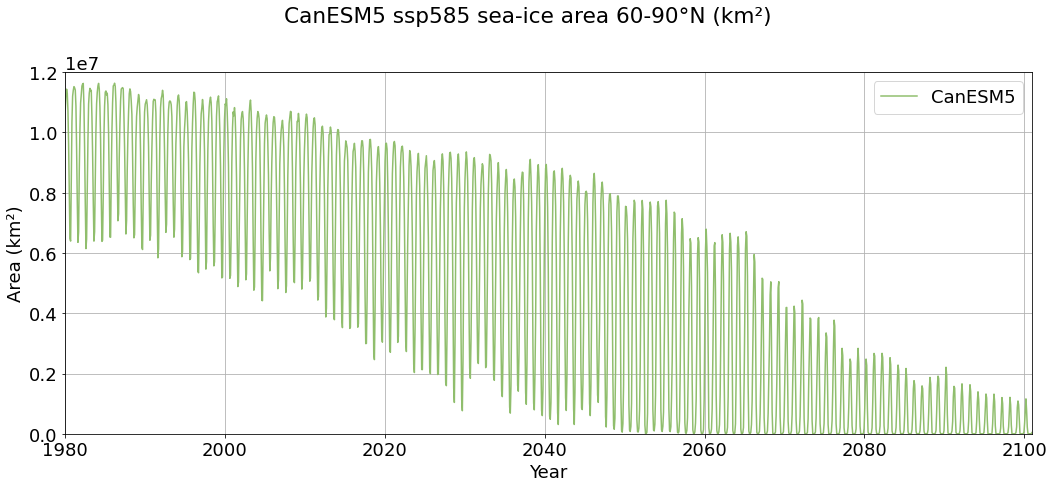

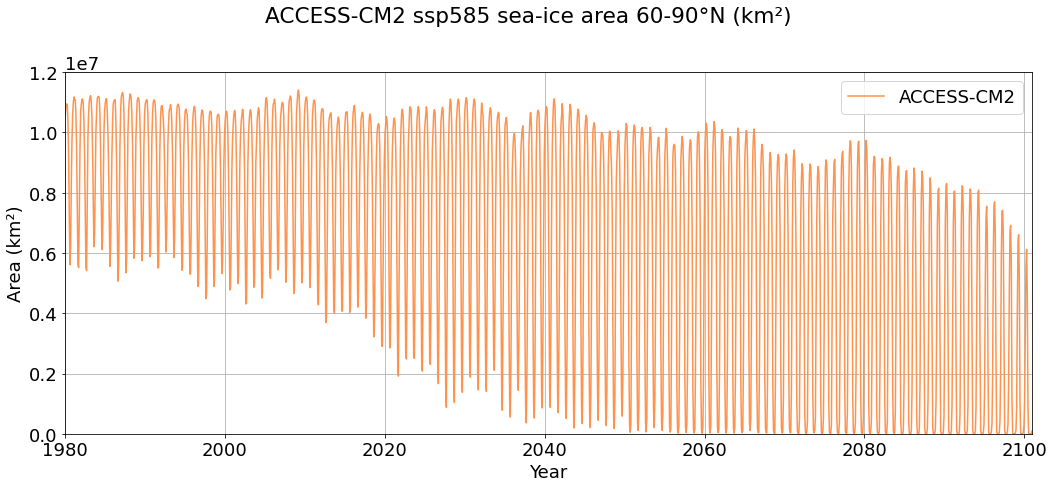

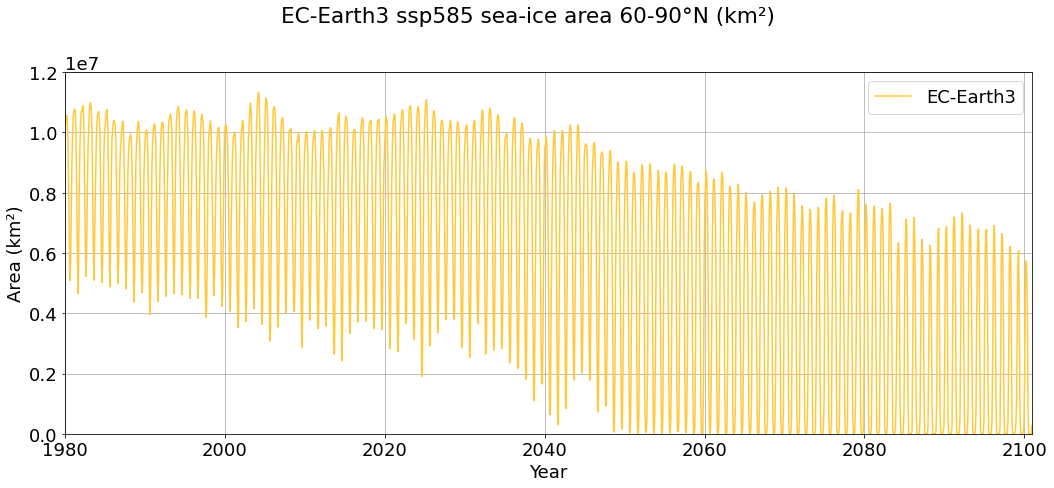

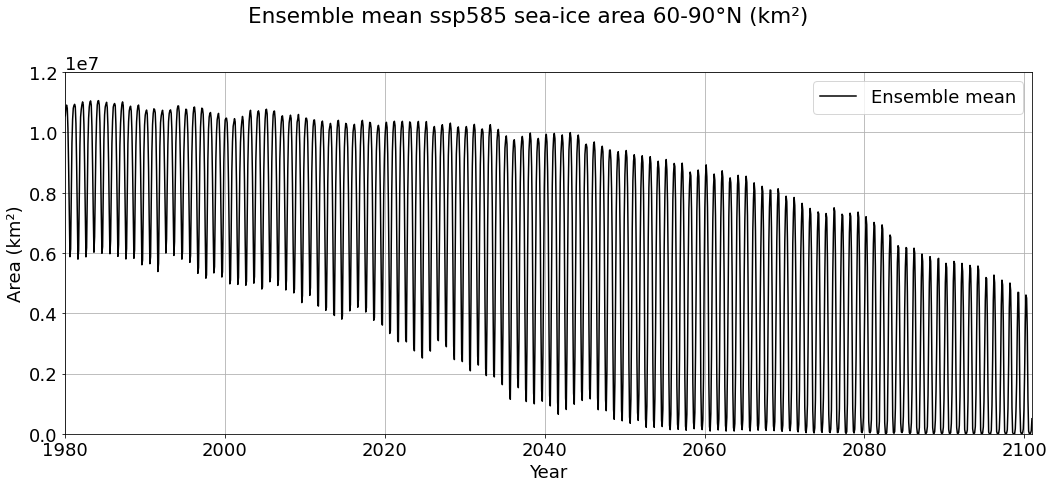

In [6]:
libs.ensemble.time_series_full_variability(
    ensemble_time_series,
    plot_kwargs={
        'title': f'{{member}} {experiment} {time_series_text} 60-90°N ({time_series_units})',
        'ylabel': time_series_y_label,
        'yrange': time_series_y_range_full
    }
)

## Monthly variability

### Full region (time)

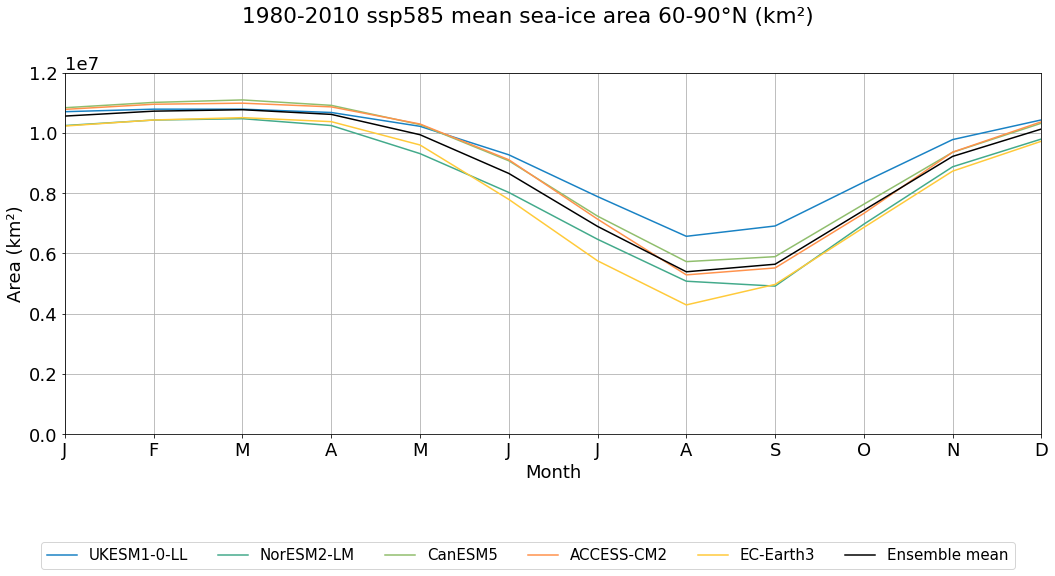

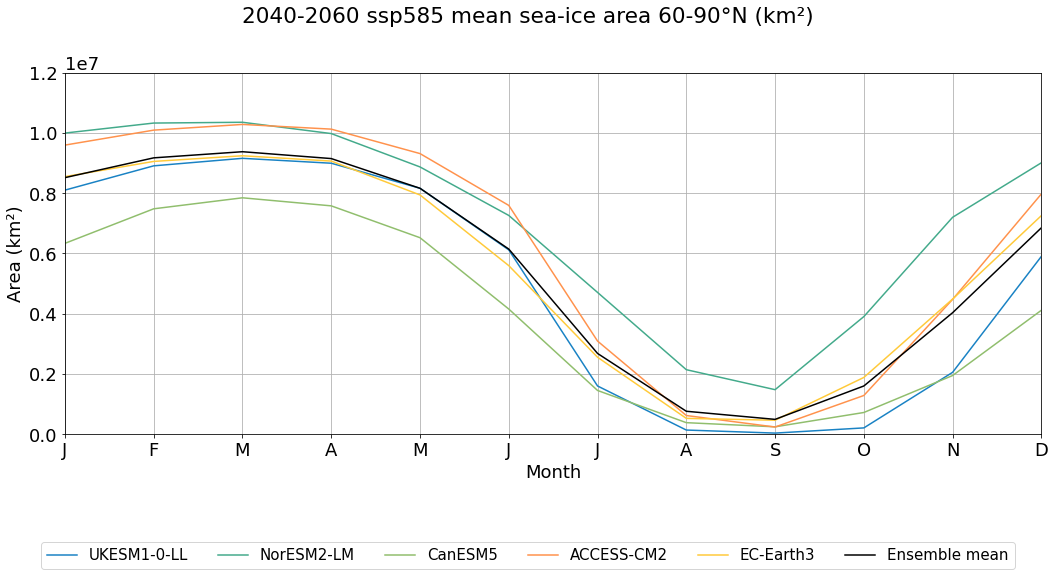

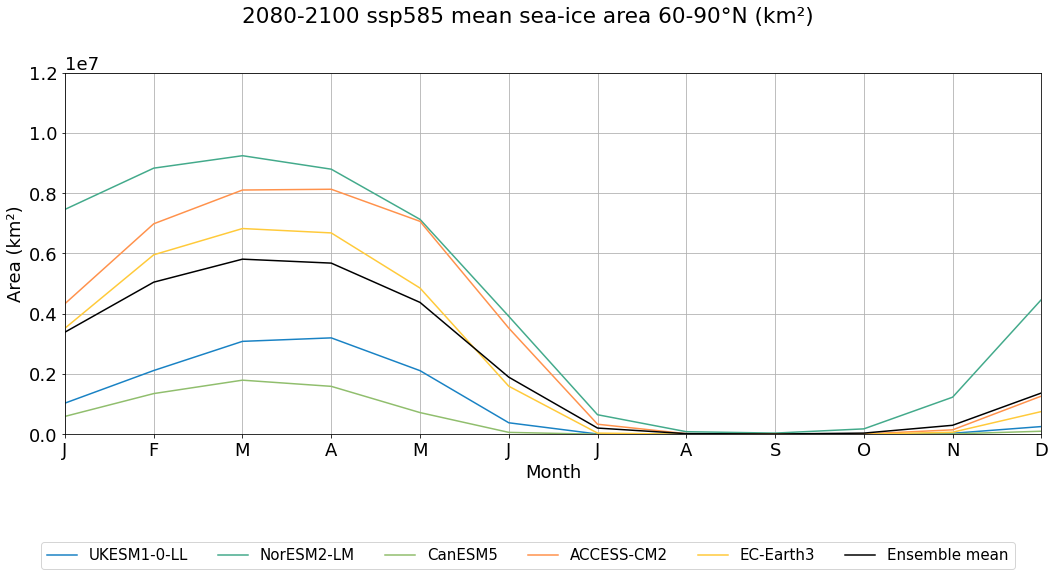

In [7]:
for s in time_slices:
    s_label = s['label']

    libs.plot.monthly_variability(
        ensemble_time_series.sel(**s['slice']).groupby('time.month').mean('time'),
        title=f'{s_label} {experiment} mean {time_series_text} 60-90°N ({time_series_units})',
        ylabel=time_series_y_label,
        yrange=time_series_y_range_monthly
    )

### Regional sea-ice area (time)

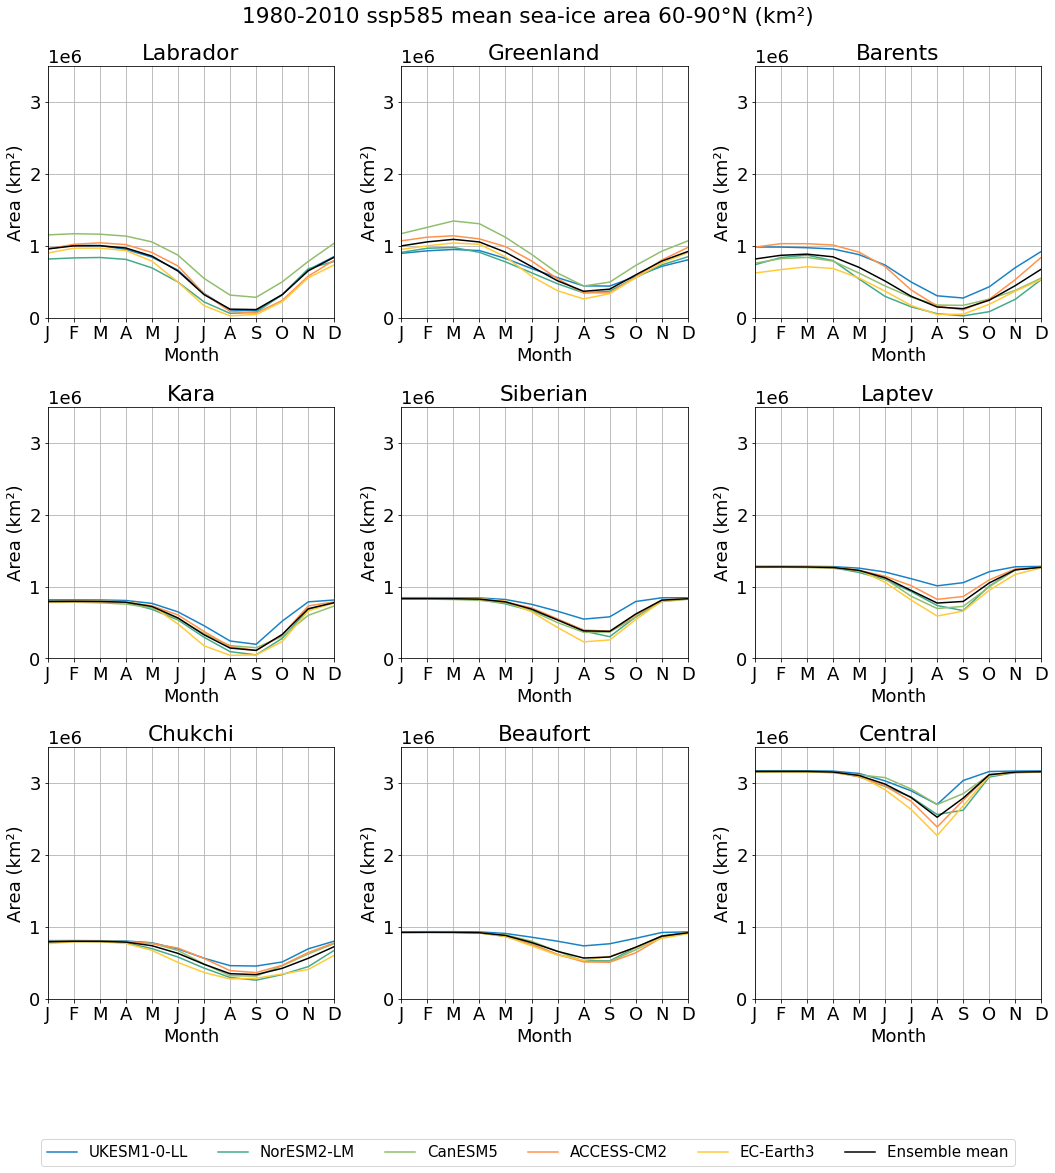

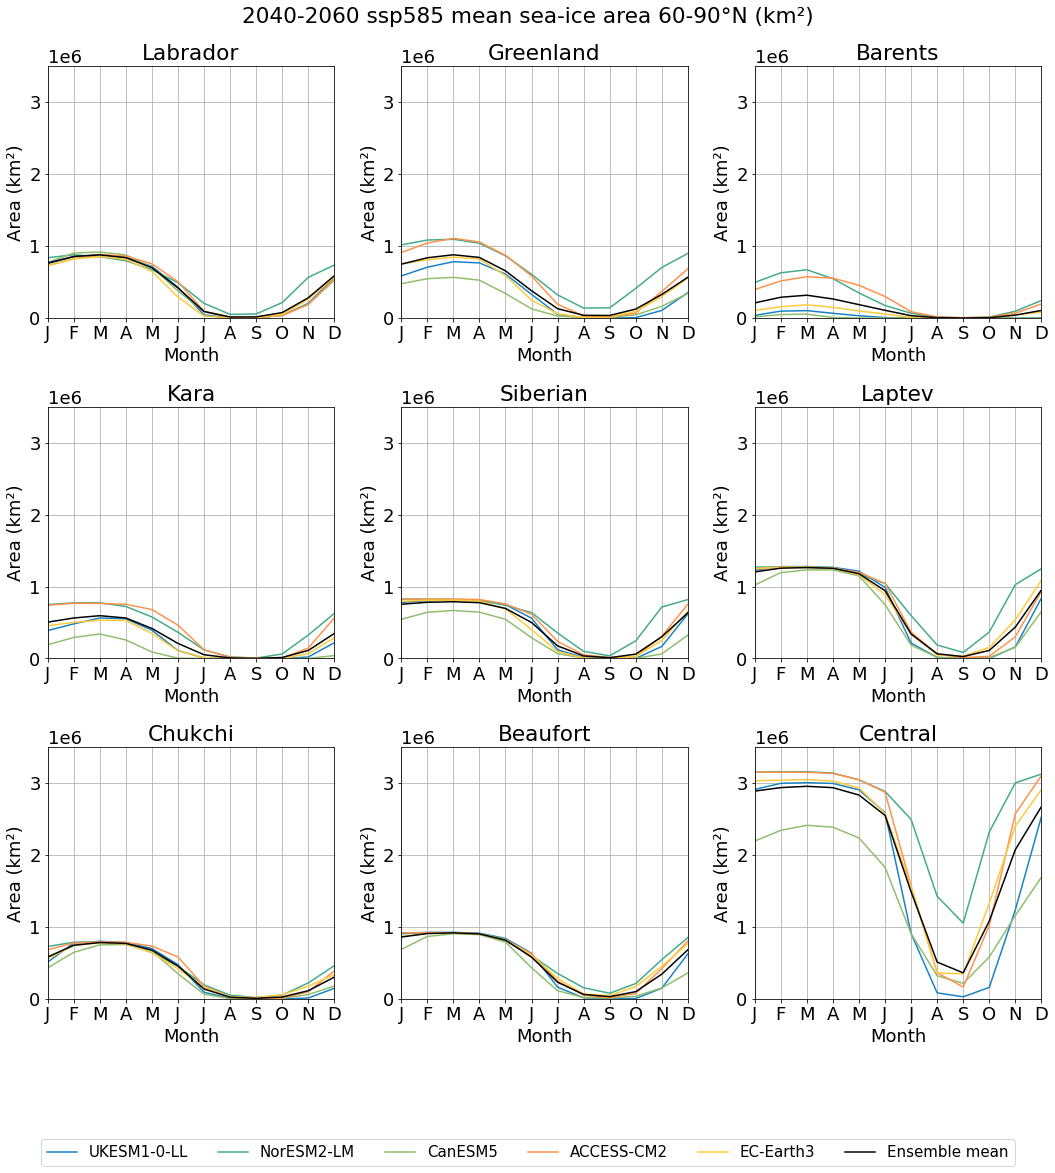

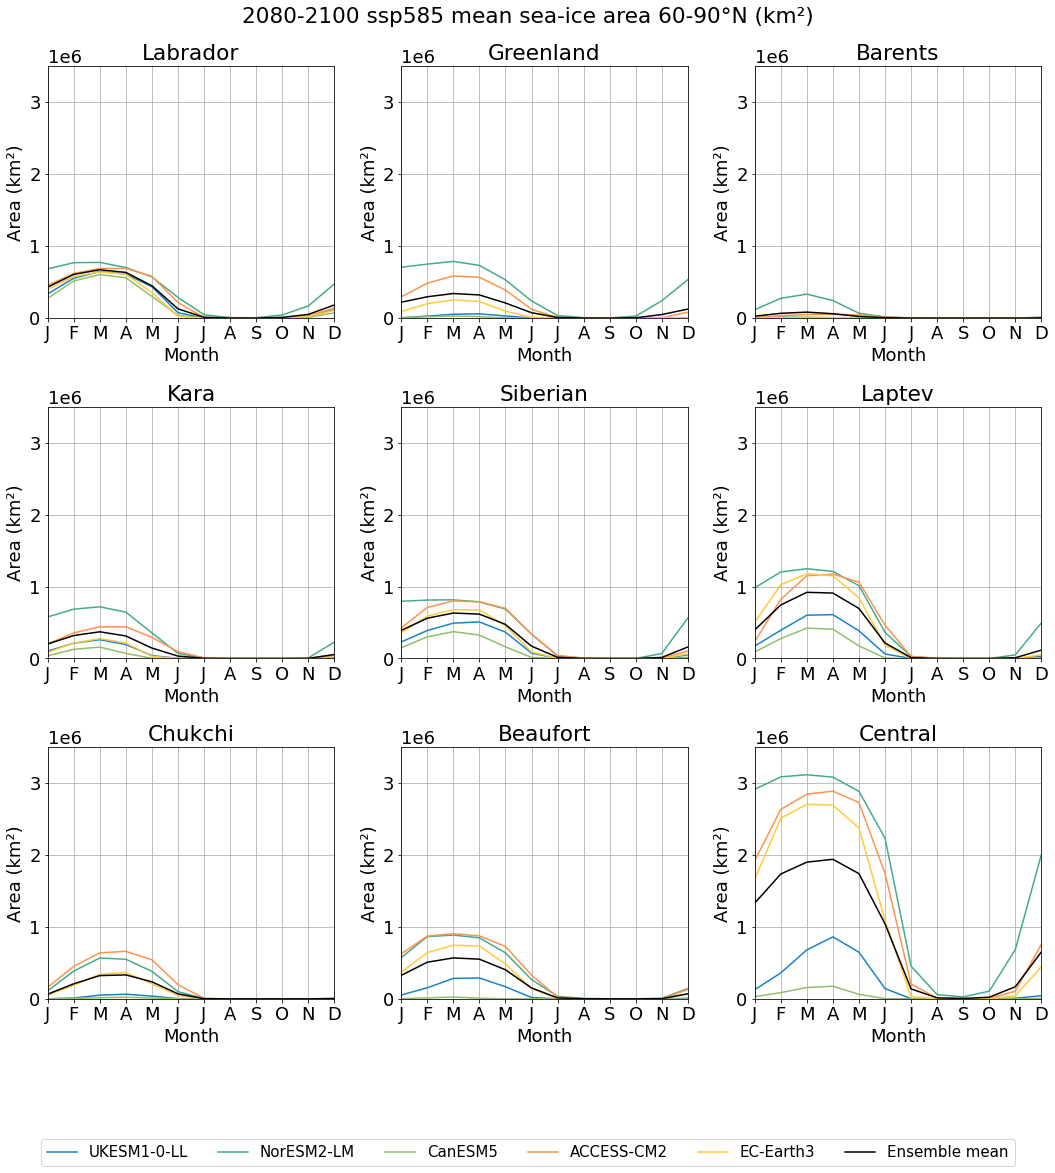

In [8]:
regions = libs.local.get_ensemble_regional_series(variable_id, experiment)

for s in time_slices:
    s_label = s['label']
    regional_time_slices = [
        data.sel(**s['slice']).groupby('time.month').mean('time') for data in regions
    ]

    libs.plot.monthly_variability_regional(
        regional_time_slices,
        title=f'{s_label} {experiment} mean {time_series_text} 60-90°N ({time_series_units})',
        ylabel=time_series_y_label,
        yrange=time_series_y_range_regional
    )

### Full region March maximum (spatial)

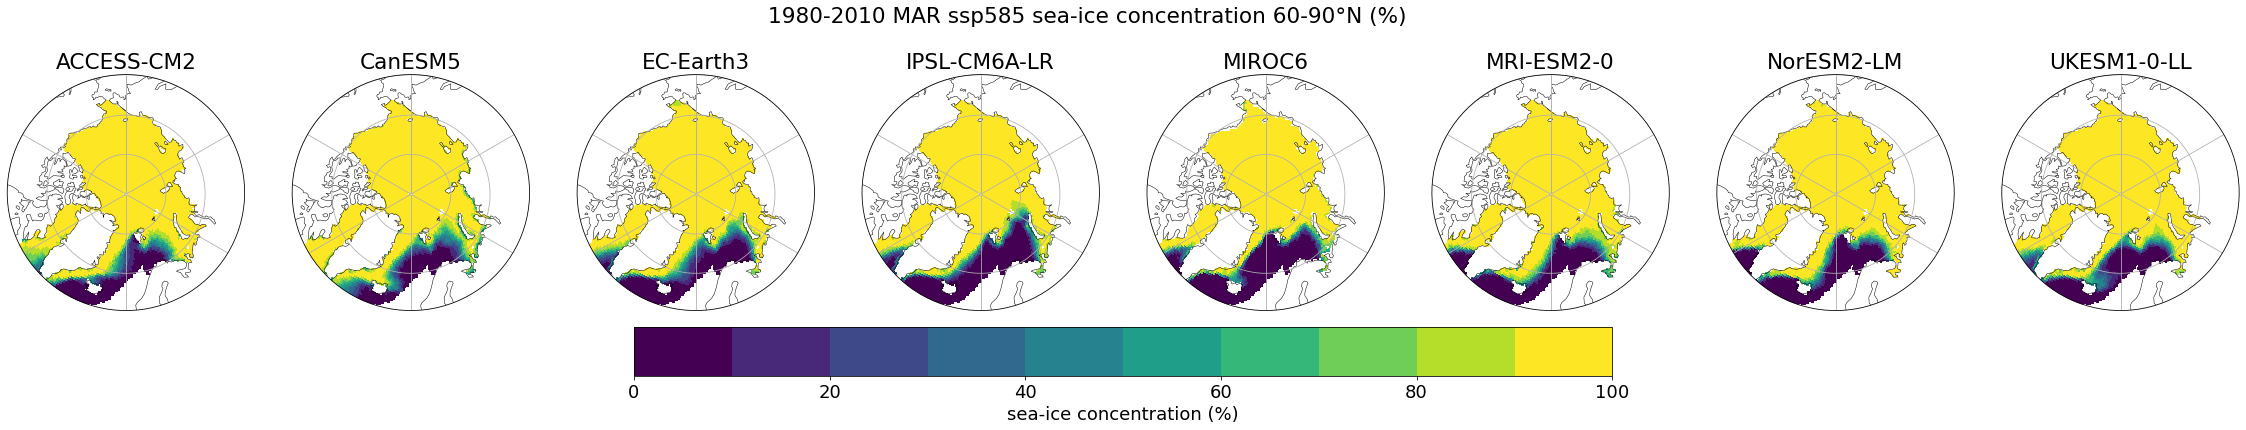

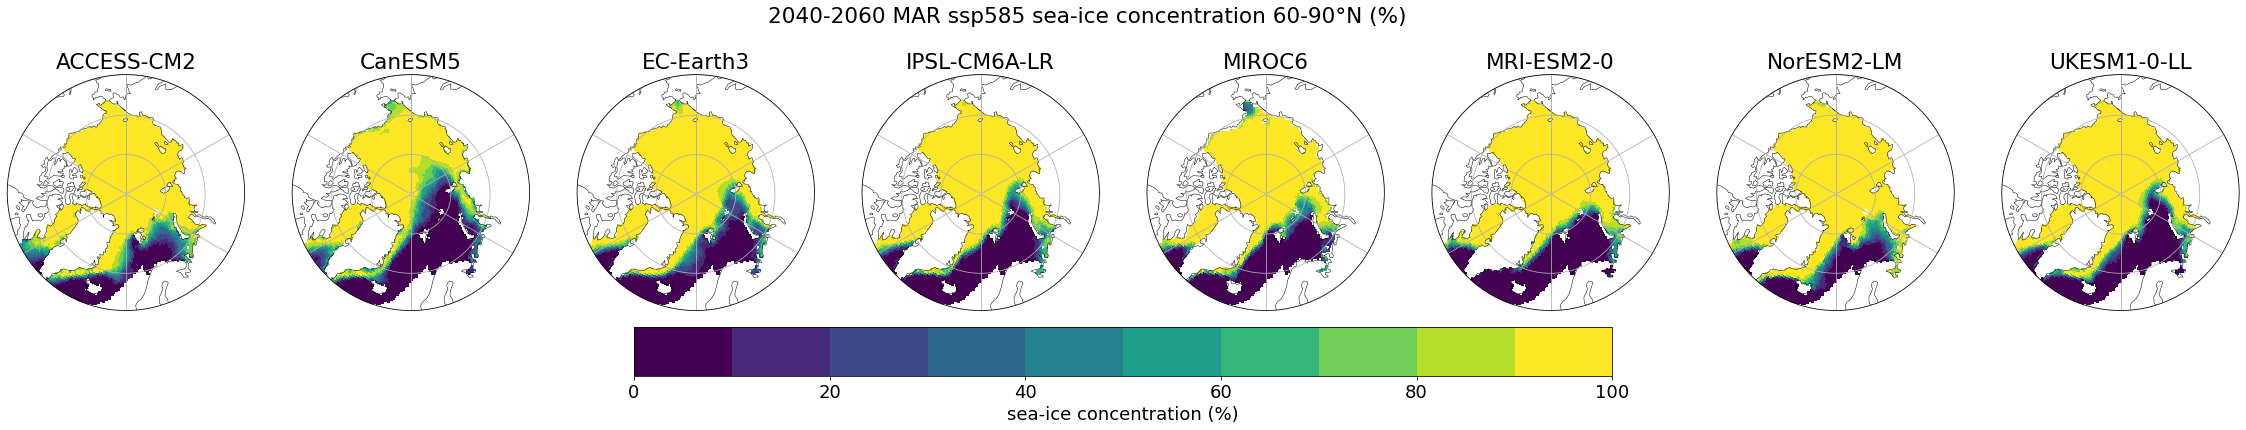

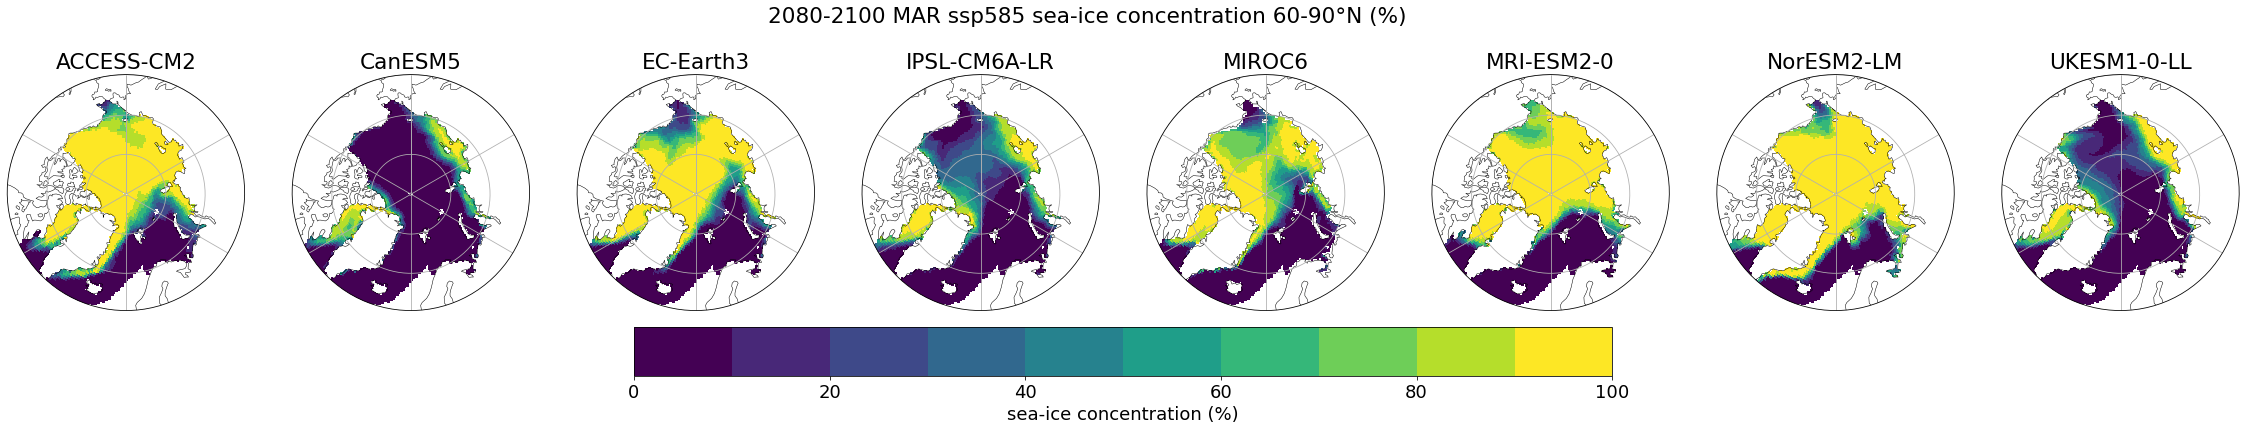

In [6]:
import warnings
warnings.filterwarnings('ignore')

libs.plot.calendar_division_spatial(
    ensemble_time_slices, 
    colormesh_kwargs=colormesh_kwargs,
    text=spatial_text,
    time='MAR',
    title='{label} {time} ssp585 {text} 60-90°N ({units})',
    units=spatial_units
)

### Full region September minimum (spatial)

/home/users/woodward/.conda/envs/climate/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/users/woodward/.conda/envs/climate/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/users/woodward/.conda/envs/climate/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/home/users/woodwar

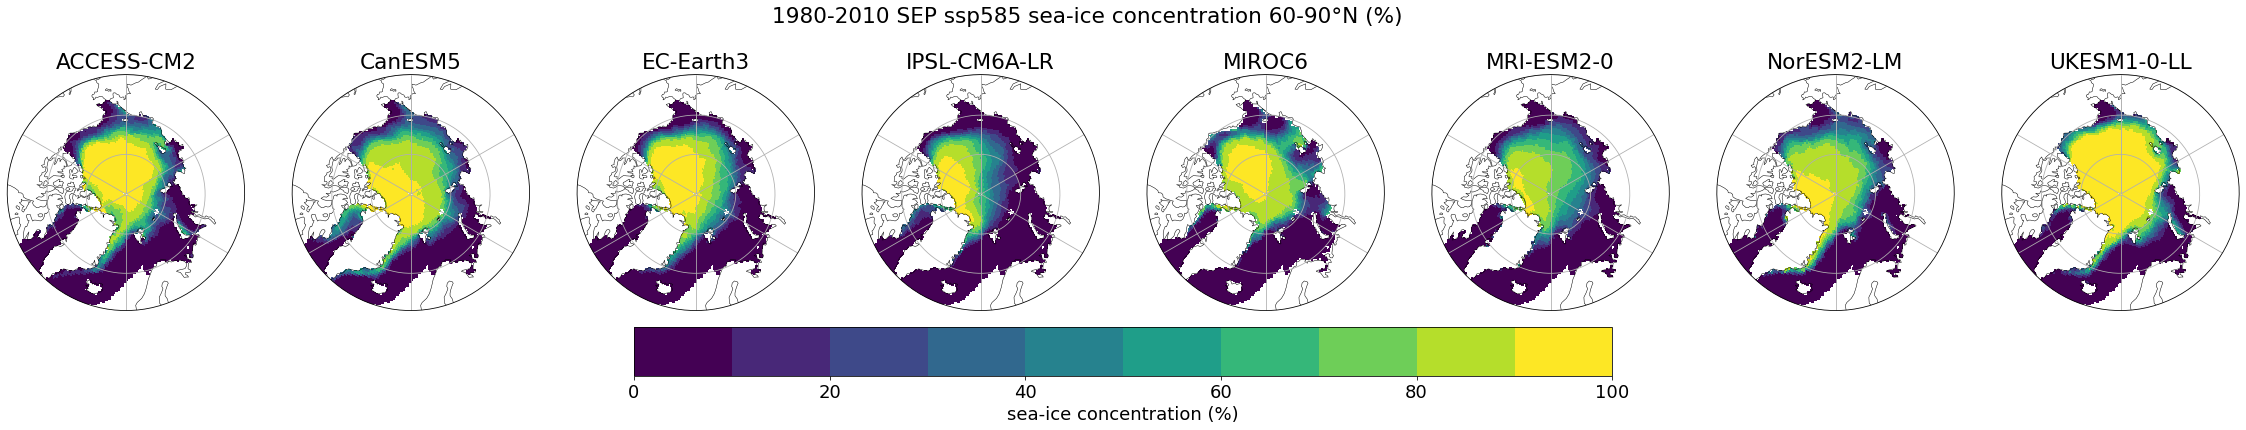

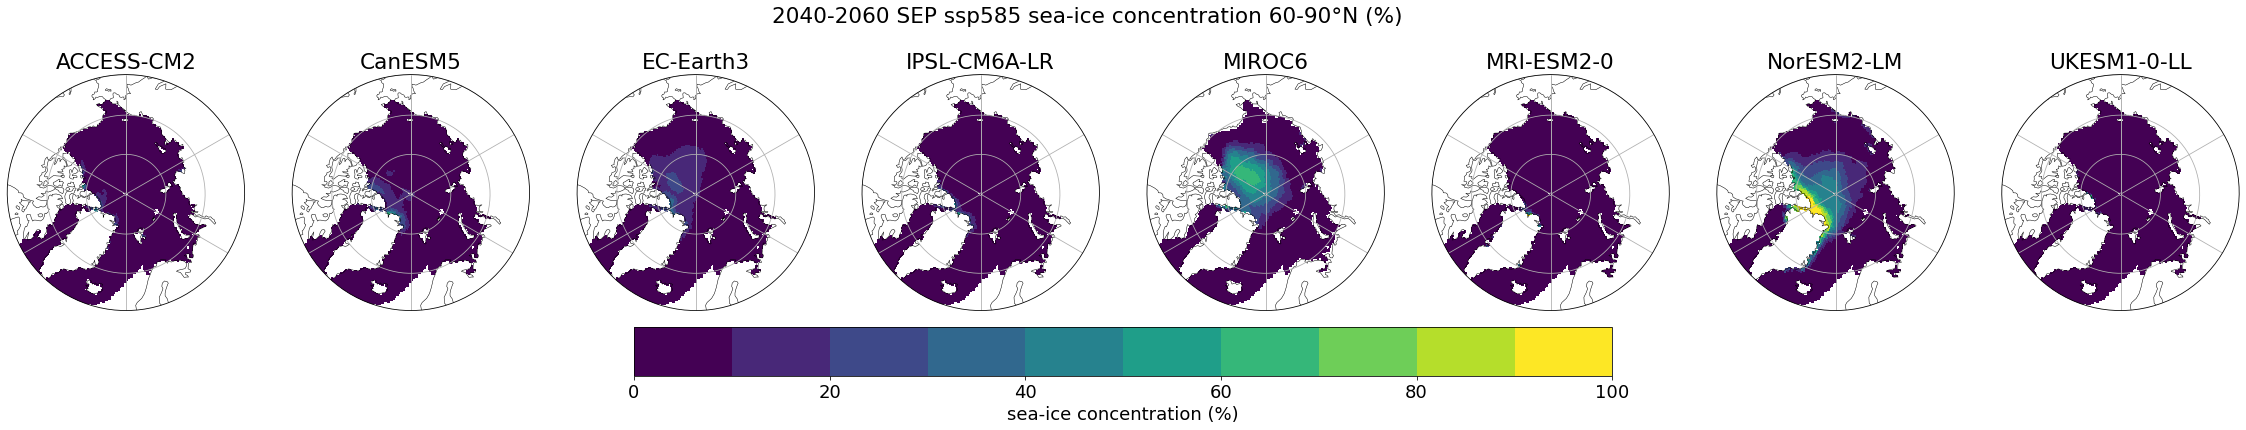

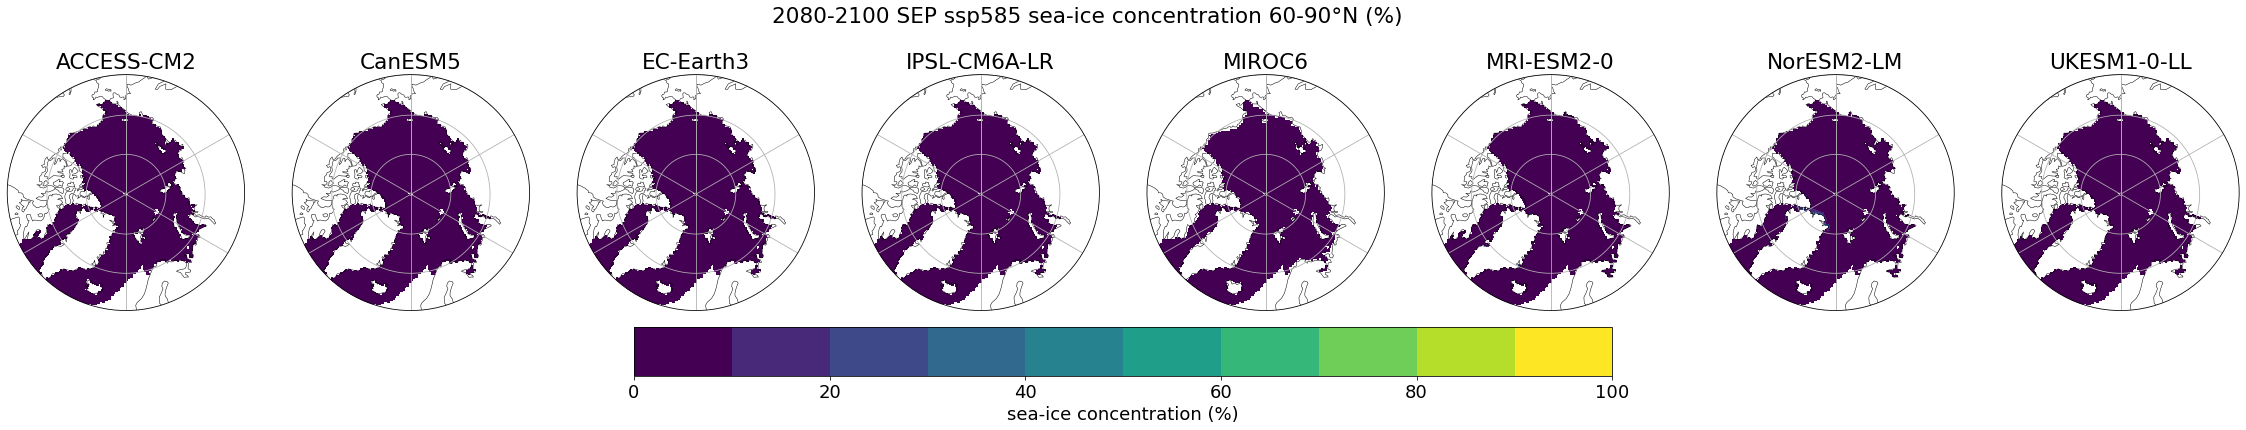

In [6]:
libs.plot.calendar_division_spatial(
    ensemble_time_slices, 
    colormesh_kwargs=colormesh_kwargs,
    text=spatial_text,
    time='SEP',
    title='{label} {time} ssp585 {text} 60-90°N ({units})',
    units=spatial_units
)